## Adjustments

In [153]:
original_structure = False
root_dir_data = "/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR"
save_pickle = True
save_path = "/Users/aljoscha/Downloads/locustVR_data"

### 0. Initialisation

#### 0.1 Set util directory

In [167]:
utilities_name = "utilities-main"
sub_dir = None
in_unitydataanalysis = True
unitydataanalysis_name = "UnityDataAnalysis-main"

import os,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib.colors import LogNorm
import importlib

import utils_local
importlib.reload(utils_local)
from utils_local import align_and_flip_heading, reindex_t_by_state_transition, convert_trial_label, plt_density, align_trajectories, flip_symmetric_states, compute_directness_and_direction, access_utilities

if original_structure:
    access_utilities()
else:
    access_utilities(utilities_name, sub_dir, in_unitydataanalysis, unitydataanalysis_name)

from useful_tools import select_animals_gpt,find_file,column_name_list,get_fill_between_range,read_seq_config
from data_cleaning import findLongestConseqSubseq,interp_fill

/Users/aljoscha/PycharmProjects/VTK_LocustVR/utilities-main


### 1. Data preparation (only necessary for new datasets)

In [155]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())

variable_name='location'
exp_name=analysis_methods.get("experiment_name")

In [156]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = 'LocustVR'
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
        animal_of_interest=select_animals_gpt(df,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df

    ID_array=animal_of_interest["ID"].values
    print(f"Valid animals IDs: \n {ID_array}")
    dir_list = [
    root.replace("\\", "/")
    for root, _, files in os.walk(root_dir_data)
    if any(ID in root for ID in ID_array)
    and any(file.endswith(file_type) for file in files)]
else:
    for root, dirs, files in os.walk(root_dir_data):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

print("Directories:")
for i in dir_list:
    print(i)

Valid animals IDs: 
 ['GN25001' 'GN25002' 'GN25003' 'GN25004' 'GN25006' 'GN25007' 'GN25008'
 'GN25009' 'GN25011' 'GN25012' 'GN25013' 'GN25014' 'GN25015' 'GN25016'
 'GN25017' 'GN25018' 'GN25020' 'GN25021' 'GN25022' 'GN25023' 'GN25024'
 'GN25025' 'GN25026']
Directories:


In [157]:
file_name = "/XY_full.h5"
pd_list = []
for index, this_dir in enumerate(dir_list):
    print(index, this_dir)
    this_pd = pd.read_hdf(this_dir + file_name)
    this_pd['animal_id'] = index
    this_pd = reindex_t_by_state_transition(this_pd, transition_from=0, transition_to=(1, 2))
    this_pd = align_and_flip_heading(this_pd)
    this_pd = convert_trial_label(this_pd)
    this_pd = align_trajectories(this_pd)
    this_pd = flip_symmetric_states(this_pd)
    this_pd = compute_directness_and_direction(this_pd)
    pd_list.append(this_pd)

df=pd.concat(pd_list,ignore_index=True)

if save_pickle:
    os.makedirs(save_path, exist_ok=True)
    df.to_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

ValueError: No objects to concatenate

### 2. Load data

In [158]:
df = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

In [159]:
print(df)
print(df['ts'].min(), df['ts'].max())
print(df['ts'].value_counts()[df['ts'].max()])

                X          Y   heading     ts  trial_id  state_type  \
0       -0.004847  -0.001845  1.378215  -9408         0           0   
1       -0.013489  -0.026297  1.335805  -9407         0           0   
2       -0.021833  -0.050318  1.335805  -9406         0           0   
3       -0.029885  -0.073905  1.408251  -9405         0           0   
4       -0.037650  -0.097059  1.408251  -9404         0           0   
...           ...        ...       ...    ...       ...         ...   
5707857  4.818589 -35.891693  1.893089   2873        18           1   
5707858  4.821211 -35.897220  1.843491   2874        18           1   
5707859  4.823629 -35.902826  1.843491   2875        18           1   
5707860  4.825835 -35.908510  1.843491   2876        18           1   
5707861  4.827820 -35.914269  1.843491   2877        18           1   

            trial_label  animal_id  heading_rel  heading_rel_flip  \
0        CD5.0_CS3.0_S1          0     0.949213          0.949213   
1        

### 3. Visualisation

In [217]:
angle_version = ["heading_rel", "heading_rel_flip"]
select = ["data", "angle", "angular_velocity"]

t_max = df['ts'].max()
sec = t_max / 60
limits = [[-3000 / sec, 8000 / sec], [-180, 180]]

plot_type = ["hist", "kde"] # Options: hist, kde

angle_bins = np.linspace(-np.pi, np.pi, 360)  # 1° bins
time_ts = [-2000, 0, 500, 1000, 6000, 9494]
critical_time1 = time_ts / sec
time_seconds = np.array([2, 10])
critical_time2 = time_seconds * sec  # Convert seconds to the same scale as 'ts'

position_version1 = ["X_flip", "Y_flip"]
position_version2 = ["X_aligned", "Y_aligned"]
position_version = [position_version1, position_version2]

def default_style(x_label, y_label):
    plt.xlim(limits[0][0], limits[0][1])
    plt.ylim(limits[1][0], limits[1][1])
    plt.grid(False)
    plt.box(True)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()

def generate_plot_type(plot_type):
    if plot_type == "hist":
        plt_hist = True
        plt_kde = False
    elif plot_type == "kde":
        plt_kde = True
        plt_hist = False
    else:
        raise ValueError("plot_type must be 'hist' or 'kde'")
    return plt_hist, plt_kde

def generate_time_windows(critical_time):
    time_windows = {}
    for i in range(len(critical_time)-1):
        row = {f"t1 ({critical_time[i]:.1f} to {critical_time[i+1]:.1f})": (critical_time[i], critical_time[i+1]),}
        time_windows.update(row)
    return time_windows



#### 3.1 Angle over time (select what to plot)

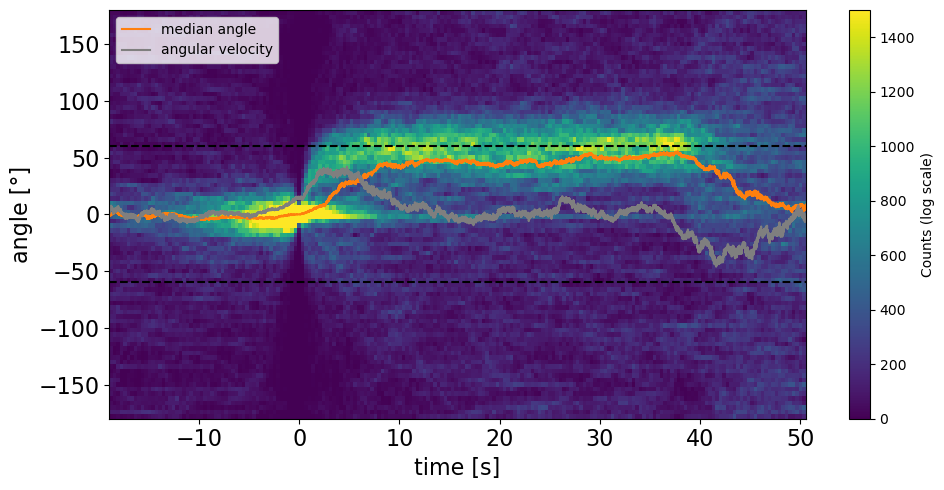

In [185]:
fig, ax = plt.subplots(figsize=(10, 5))
for version in angle_version:
    if "data" in select:
        # Prepare data
        x = df['ts'] / sec
        y = np.degrees(df[version])

        # Heatmap with log color normalization for better contrast
        heatmap = ax.hist2d(
            x, y,
            bins=[200, 90],  # time x angle resolution
            range=[[limits[0][0], limits[0][1]], [limits[1][0], limits[1][1]]],
            cmap='viridis',
            # norm=LogNorm(vmin=1, vmax=1000),
            density=False,
            vmax=1500
        )

        cbar = fig.colorbar(heatmap[3], ax=ax)
        cbar.set_label("Counts (log scale)")

    # Median angle
    df_mean = df.groupby('ts', as_index=False)[version].median()
    if "angle" in select:
        ax.plot(df_mean['ts'] / sec, np.degrees(df_mean[version]), color='C1', label='median angle')

    # Angular velocity
    df_median = df.groupby('ts', as_index=False)[version].median()
    df_median = df_median.sort_values('ts')
    df_median['heading_smooth'] = df_median[version].rolling(window=700, center=True).mean()
    df_median['angular_velocity'] = df_median['heading_smooth'].diff() / df_median['ts'].diff()
    df_median = df_median.dropna(subset=['angular_velocity'])

    if "angular_velocity" in select:
        ax.plot(df_median['ts'] / sec, np.degrees(df_median['angular_velocity'] * 1000), color='tab:gray', label='angular velocity')

    # ±60° reference
    ax.axhline(60, color='black', linestyle='--')
    ax.axhline(-60, color='black', linestyle='--')

    # Labels, limits, legend
    default_style(x_label="time [s]", y_label="angle [°]")
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.legend(loc='upper left')

    plt.savefig(os.path.join(save_path, 'angle_vs_time_heatmap.png'), format='png', dpi=500)
    plt.show()

#### 3.2 Desity of angles (for time bins)

##### 3.2.1 Histogram

heading_rel


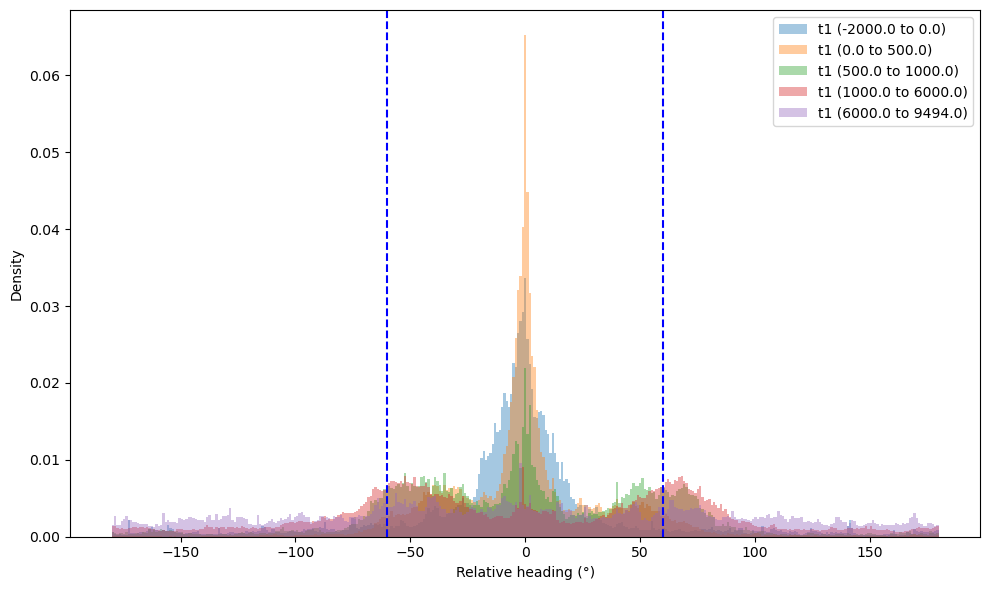

heading_rel_flip


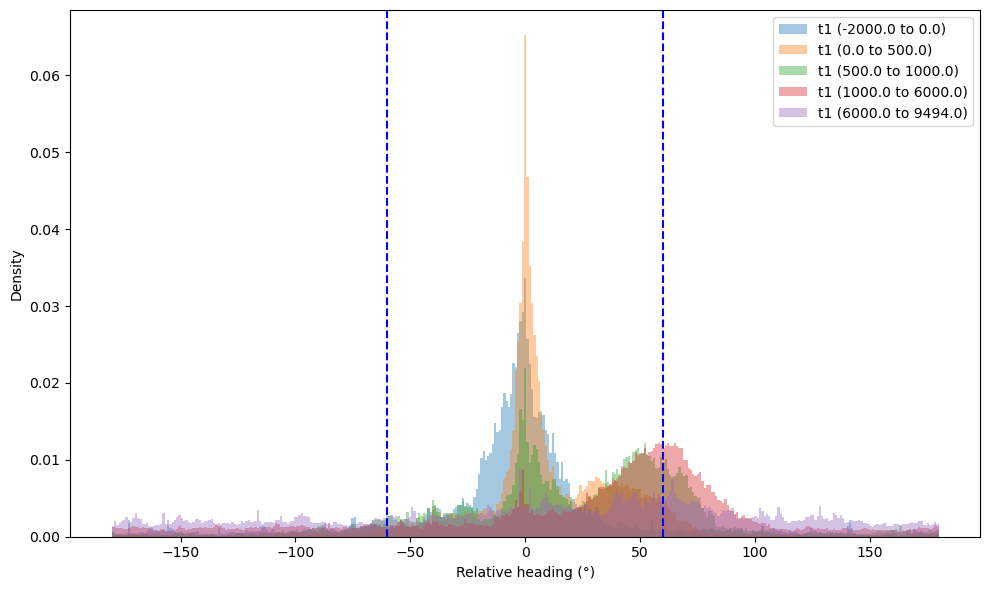

heading_rel


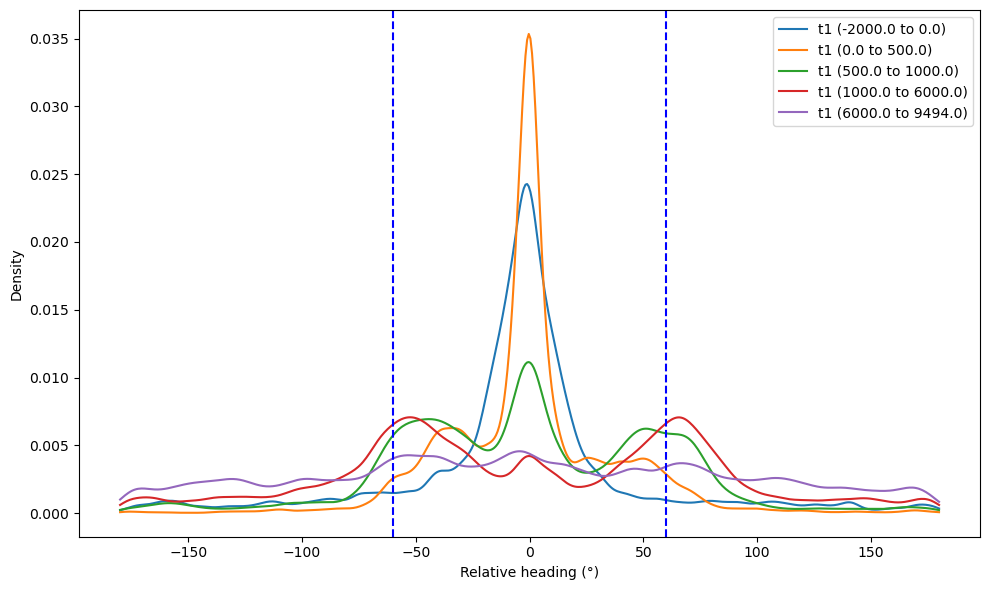

heading_rel_flip


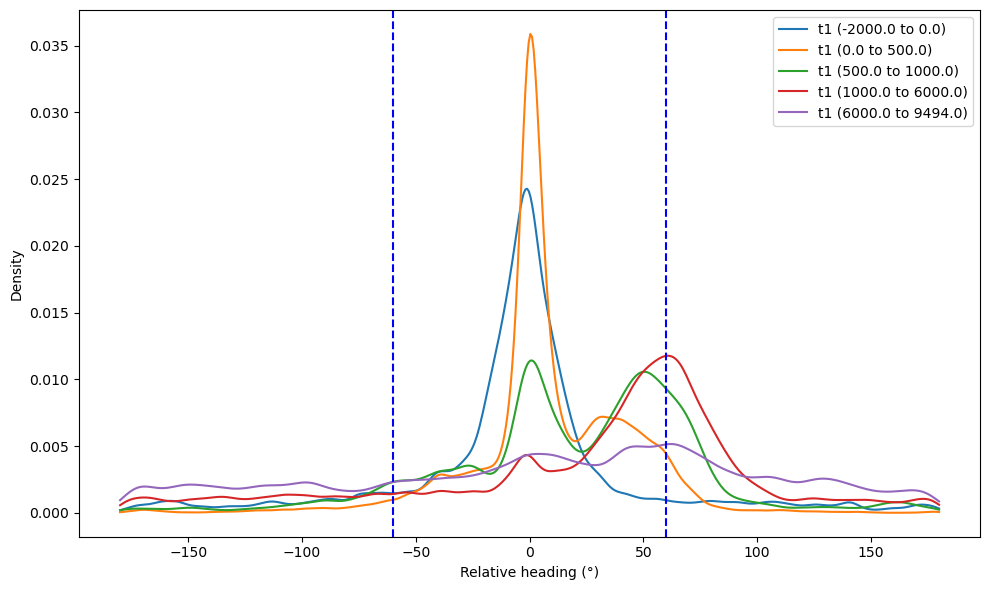

In [216]:
time_windows = generate_time_windows(critical_time1)
for type in plot_type:
    plt_hist, plt_kde = generate_plot_type(type)
    for version in angle_version:
        print(version)
        plt.figure(figsize=(10, 6))
        plt_density(df, version, time_windows, angle_bins, plt_hist=plt_hist, plt_kde=plt_kde, label2=time_windows.keys())
        plt.savefig(os.path.join(save_path, f'{type}_{version}.png'), format='png', dpi=500)
        plt.show()

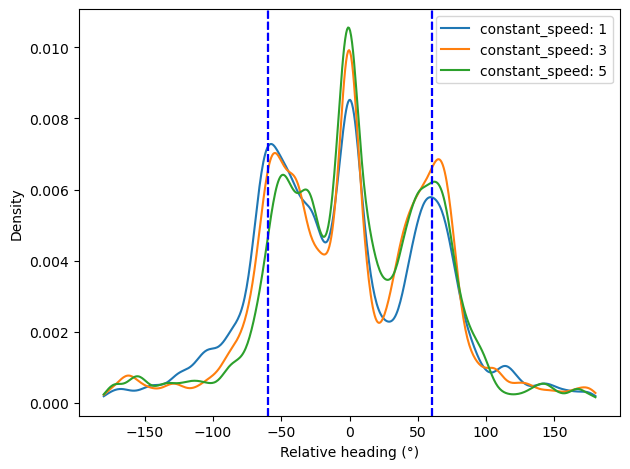

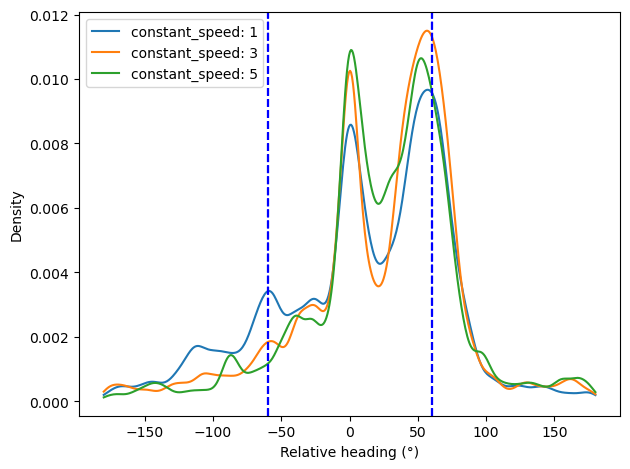

In [215]:
list_parameters = ["constant_speed"]

time_windows = generate_time_windows(critical_time2)
for version in angle_version:
    def group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=False):
        grouped = df.groupby(list_parameters)
        for groupvalues, group in grouped:
            label2 = ""
            for i in range(len(list_parameters)):
                if i > 0:
                    label2 += ", "
                label2 += f"{list_parameters[i]}: {groupvalues[i]}"
            plt_density(group, version, time_windows, angle_bins, plt_hist , plt_kde,label2=label2)
        plt.savefig(os.path.join(save_path, f'{list_parameters[i]}_{type}_{version}.png'), format='png', dpi=500)
        plt.show()
    group_select(df, list_parameters, version, time_windows, angle_bins, plt_hist=False, plt_kde=True)


#### 3.3 Trajectories (preliminary!)

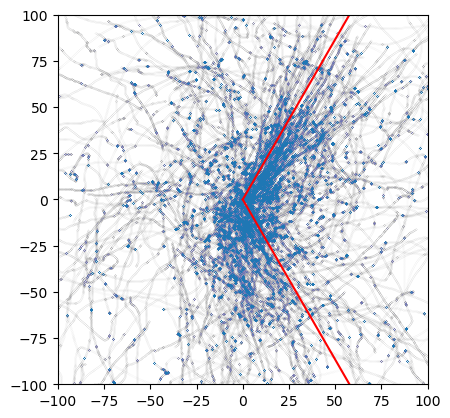

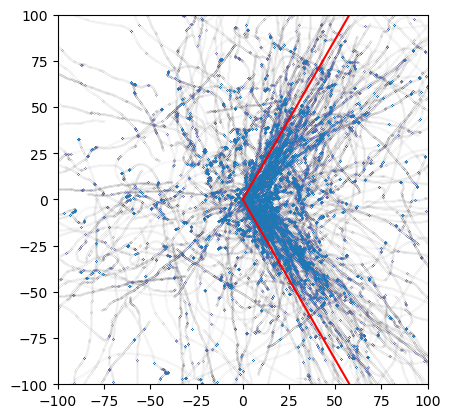

In [219]:
for version in position_version:
    mask = (df["ts"] >= 1000) & (df["ts"] < 6000)
    plt.scatter(-df.loc[mask, version[0]], -df.loc[mask, version[1]], s=0.02, alpha=0.01)

    # plt.scatter(df.loc[mask, 'X'], df.loc[mask, 'Y'], s=0.06, alpha=0.03)
    # plt.scatter(df['X_aligned'][0:9494], df['Y_aligned'][0:9494], s=0.06, alpha=0.03)
    # plt.scatter(df['X'], df['Y'], s=0.06, alpha=0.03)#, c=df['trial_id'], cmap='viridis')
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.gca().set_aspect('equal')

    X = np.linspace(0, 100, 500)

    # Calculate Y based on angle
    angle_deg = 60
    slope = np.tan(np.radians(angle_deg))

    Y = slope * X
    plt.plot(X, Y, color='red')
    plt.plot(X, -Y, color='red')
    plt.savefig(os.path.join(save_path, f'locustvr_trajectories_{version[0]}.png'), format='png', dpi=300)
    plt.show()

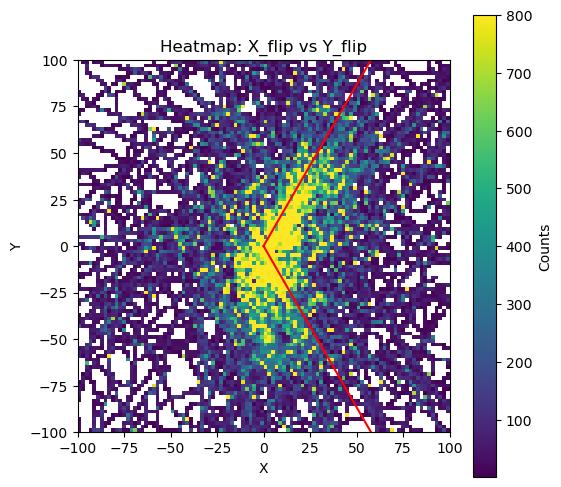

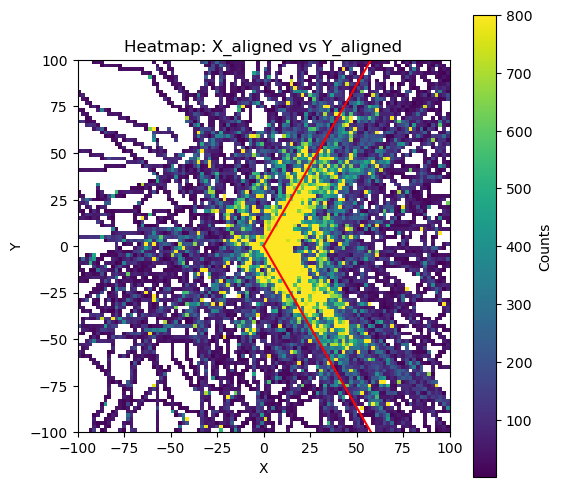

In [224]:
import matplotlib.pyplot as plt
import numpy as np

for version in position_version:
    mask = (df["ts"] >= 1000) & (df["ts"] < 6000)
    x = -df.loc[mask, version[0]]
    y = -df.loc[mask, version[1]]

    fig, ax = plt.subplots(figsize=(6, 6))

    # 2D Histogram Heatmap
    heatmap = ax.hist2d(
        x, y,
        bins=[400, 400],
        range=[[-400, 400], [-400, 400]],
        cmap='viridis',
        density=False,
        cmin=1,     # hide empty bins
        vmax=800    # optional: cap for contrast
    )
    fig.colorbar(heatmap[3], ax=ax).set_label("Counts")

    # ±60° guides
    X = np.linspace(0, 100, 500)
    angle_deg = 60
    slope = np.tan(np.radians(angle_deg))
    Y = slope * X
    ax.plot(X, Y, color='red')
    ax.plot(X, -Y, color='red')

    # Plot formatting
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(f"Heatmap: {version[0]} vs {version[1]}")

    # Uncomment if saving
    plt.savefig(os.path.join(save_path, f'locustvr_trajectories_heatmap_{version[0]}.png'), format='png', dpi=300)
    plt.show()

In [135]:
"""
Todo:
Clean up

Density direction trajectory (direct)
exclude if d_direct < threshold
plot directness vs angle direct
plot directness vs speed
plot speed vs angle direct
annotate left right with CS, CD

threshold decision
"""

'\nTodo:\nClean up\nImplement:\nMSD\nDirectness\nDensity direction trajectory (direct)\nexclude if d_direct < threshold\nplot directness vs angle direct\nplot directness vs speed\nplot speed vs angle direct\nannotate left right with CS, CD\nplot trajectories add direction to targets\n'